<a href="https://colab.research.google.com/github/VynLavenda/Topic-and-Theme-Detection-in-a-Text-Corpus/blob/main/%20Topic%20and%20Theme%20Detection%20in%20a%20Text%20Corpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UAS Natural Language Processing
Evelyn

36230029

Alaniah Nisrina, B.Eng., M.Eng.

Sumber Dataset: Kaggle
https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import gdown

file_id = "1fXBwd58m-6UlIHRkggOqAPDmUOe3VjgF"
url = f"https://drive.google.com/uc?id={file_id}"
output = "hasil_download.csv"
gdown.download(url, output, quiet=False)
print("Download selesai! File tersimpan sebagai:", output)

Downloading...
From (original): https://drive.google.com/uc?id=1fXBwd58m-6UlIHRkggOqAPDmUOe3VjgF
From (redirected): https://drive.google.com/uc?id=1fXBwd58m-6UlIHRkggOqAPDmUOe3VjgF&confirm=t&uuid=4b4299e6-ac12-4ccb-ab1c-e03bae4d61e3
To: /content/hasil_download.csv
100%|██████████| 800M/800M [00:02<00:00, 271MB/s]

Download selesai! File tersimpan sebagai: hasil_download.csv


In [ ]:
df = pd.read_csv("hasil_download.csv")
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
df.info()

# Jumlah baris dan kolom
print(f"Jumlah sample: {df.shape[0]}")
print(f"Jumlah fitur: {df.shape[1]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB
Jumlah sample: 681284
Jumlah fitur: 7


In [ ]:
df.describe()

,id,age
count,6.812840e+05,681284.000000
mean,2.397802e+06,23.932326
std,1.247723e+06,7.786009
min,5.114000e+03,13.000000
25%,1.239610e+06,17.000000
50%,2.607577e+06,24.000000
75%,3.525660e+06,26.000000
max,4.337650e+06,48.000000


# Preprocessing Awal

In [ ]:
print("\n=== Missing Value per Kolom ===")
print(df.isnull().sum())


=== Missing Value per Kolom ===
id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64


In [ ]:
# Drop fitur yang tidak digunakan dalam topic modelling
df = df.drop(columns=['id', 'gender', 'age', 'topic', 'sign', 'date'])

print("Kolom setelah drop:", df.columns)
print("Shape baru:", df.shape)
df.head()

Kolom setelah drop: Index(['text'], dtype='object')
Shape baru: (681284, 1)


,text
0,"Info has been found (+/- 100 pages,..."
1,These are the team members: Drewe...
2,In het kader van kernfusie op aarde...
3,testing!!! testing!!!
4,Thanks to Yahoo!'s Toolbar I can ...


In [ ]:
# Hanya mengambil 75% data
df = df.sample(frac=0.75, random_state=42).reset_index(drop=True)
print("Shape setelah mengambil 75% data:", df.shape)
df.head()

Shape setelah mengambil 75% data: (510963, 1)


,text
0,1 Corinthians 5:11 'But now I have wri...
1,Having moved to Jersey City nearly a mo...
2,"urlLink Hey, Metro! Need To Save..."
3,The most hilarious movie I have s...
4,Short of being attached to the b...


In [ ]:
print("\n=== Jumlah Duplikasi pada Kolom text ===")
print(df.duplicated(subset=["text"]).sum())

df = df.drop_duplicates(subset=["text"])
print("Shape setelah drop duplicates:", df.shape)


=== Jumlah Duplikasi pada Kolom text ===
44365
Shape setelah drop duplicates: (466598, 1)


In [ ]:
# Bersihkan whitespace / karakter kosong
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"].str.len() > 0]

In [ ]:
#Recalculate text_len
df["text_len"] = df["text"].apply(lambda x: len(x.split()))
df = df[df["text_len"] > 5]

In [ ]:
df["text_len"] = df["text"].astype(str).apply(lambda x: len(x.split()))
df["text_len"].describe()

,text_len
count,450466.000000
mean,214.026539
std,356.328760
min,6.000000
25%,47.000000
50%,126.000000
75%,271.000000
max,56045.000000


In [ ]:
# Buang teks dengan kurang dari 5 kata (noise untuk topic modelling)
df = df[df["text_len"] > 5]
print("Shape setelah buang teks pendek:", df.shape)

Shape setelah buang teks pendek: (450466, 2)


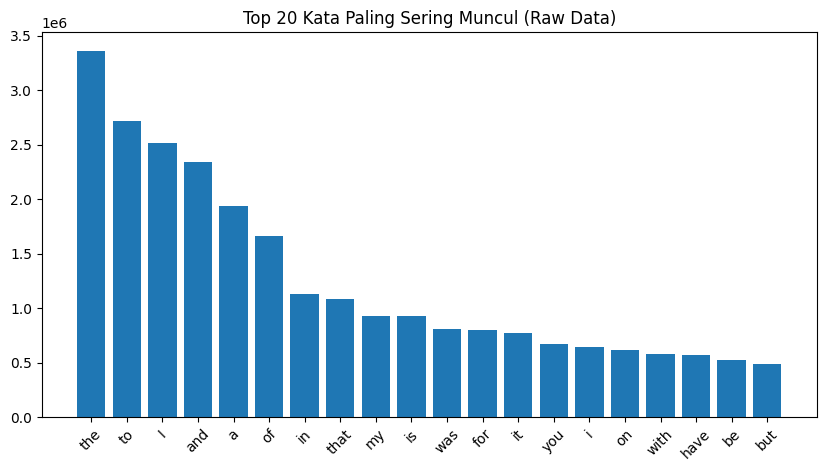

In [ ]:
# TOP WORDS (RAW)

raw_text = " ".join(df["text"].astype(str))
raw_words = raw_text.split()

word_freq = Counter(raw_words).most_common(20)

words = [w for w, c in word_freq]
counts = [c for w, c in word_freq]

plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Kata Paling Sering Muncul (Raw Data)")
plt.show()

In [ ]:
df["text"].sample(5, random_state=42)

,text
193537,"Thanks to my investigative journalism, the Pen..."
146589,"15 years ago when I was in fifth grade, the mo..."
361023,Nicole likes this better than sushi&nbsp; urlL...
147106,urlLink 100 Mistakes for the President to Choo...
118152,urlLink EPIC - Eclipse Perl Integration EPIC...


# Preprocessing Utama

In [ ]:
!pip install langdetect
import langdetect
import nltk
import spacy
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993332 sha256=9495078aed2564eab8fc8ed1be7a10ea90f97b8a7d4296c23f5acfb3072de89f
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install pandarallel
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

def detect_lang_fast(text):
    try:
        short_text = text[:300]
        return langdetect.detect(short_text)
    except:
        return "unknown"

df["lang"] = df["text"].parallel_apply(detect_lang_fast)
df = df[df["lang"] == "en"].reset_index(drop=True)

print("Sisa data setelah filter bahasa:", df.shape)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16714 sha256=bce234f23634bba73973e78c460d8725f21dada2a3a0abfacdf04bc53367911f
  Stored in directory: /root/.cache/pip/wheels/46/f9/0d/40c9cd74a7cb8dc8fe57e8d6c3c19e2c730449c0d3f2bf66b5
Successfully built pandarallel
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Sisa data setelah filter bahasa: (442926, 3)


In [ ]:
def clean_text(text):
    # 1. Lowercase (normalization)
    text = text.lower()

    # 2. Remove URLs (menghindari noise)
    text = re.sub(r'http\S+|www.\S+', '', text)

    # 3. Remove non-alphabetic characters
    # (angka & simbol biasanya tidak membantu)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 4. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
def remove_stopwords(text):
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

df["no_stopwords"] = df["clean_text"].apply(remove_stopwords)

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()
    lemmas = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(lemmas)

df["lemma_text"] = df["no_stopwords"].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
df[["text", "clean_text", "no_stopwords", "lemma_text"]].head()

,text,clean_text,no_stopwords,lemma_text
0,1 Corinthians 5:11 'But now I have written to ...,corinthians but now i have written to you not ...,corinthians written keep company anyone named ...,corinthian written keep company anyone named b...
1,Having moved to Jersey City nearly a month ago...,having moved to jersey city nearly a month ago...,moved jersey city nearly month ago idea would ...,moved jersey city nearly month ago idea would ...
2,"urlLink Hey, Metro! Need To Save Money? Take a...",urllink hey metro need to save money take a hi...,urllink hey metro need save money take hike co...,urllink hey metro need save money take hike co...
3,The most hilarious movie I have seen this year...,the most hilarious movie i have seen this year...,hilarious movie seen year comedy movie absolut...,hilarious movie seen year comedy movie absolut...
4,Short of being attached to the bumper of a pic...,short of being attached to the bumper of a pic...,short attached bumper pickup truck cock ring d...,short attached bumper pickup truck cock ring d...


In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,      # membatasi fitur agar efisien
    ngram_range=(1,2),      # unigram + bigram
    min_df=5,               # kata muncul minimal 5 dokumen
    max_df=0.8              # menghapus kata yg terlalu sering (>80%)
)

X_tfidf = tfidf.fit_transform(df["lemma_text"])
X_tfidf.shape

(442926, 5000)

In [ ]:
# Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features=5000)
X_count = count_vect.fit_transform(df["lemma_text"])
X_count.shape

(442926, 5000)

In [ ]:
df

,text,text_len,lang,clean_text,no_stopwords,lemma_text
0,1 Corinthians 5:11 'But now I have written to ...,157,en,corinthians but now i have written to you not ...,corinthians written keep company anyone named ...,corinthian written keep company anyone named b...
1,Having moved to Jersey City nearly a month ago...,492,en,having moved to jersey city nearly a month ago...,moved jersey city nearly month ago idea would ...,moved jersey city nearly month ago idea would ...
2,"urlLink Hey, Metro! Need To Save Money? Take a...",44,en,urllink hey metro need to save money take a hi...,urllink hey metro need save money take hike co...,urllink hey metro need save money take hike co...
3,The most hilarious movie I have seen this year...,310,en,the most hilarious movie i have seen this year...,hilarious movie seen year comedy movie absolut...,hilarious movie seen year comedy movie absolut...
4,Short of being attached to the bumper of a pic...,1571,en,short of being attached to the bumper of a pic...,short attached bumper pickup truck cock ring d...,short attached bumper pickup truck cock ring d...
...,...,...,...,...,...,...
442921,"Walter Morris, 13 year-old son of former KJHK ...",44,en,walter morris year old son of former kjhk staf...,walter morris year old son former kjhk staffer...,walter morris year old son former kjhk staffer...
442922,so i guess in thailand people urlLink own gia...,117,en,so i guess in thailand people urllink own gian...,guess thailand people urllink giant cockroache...,guess thailand people urllink giant cockroach ...
442923,It's another Tuesday night and I ain't got nob...,336,en,it s another tuesday night and i ain t got nob...,another tuesday night got nobody nah money eit...,another tuesday night got nobody nah money eit...
442924,"We Stand United, We Stand Strong We ...",411,en,we stand united we stand strong we stand unite...,stand united stand strong stand united stand s...,stand united stand strong stand united stand s...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 15.2 MB/s eta 0:00:00


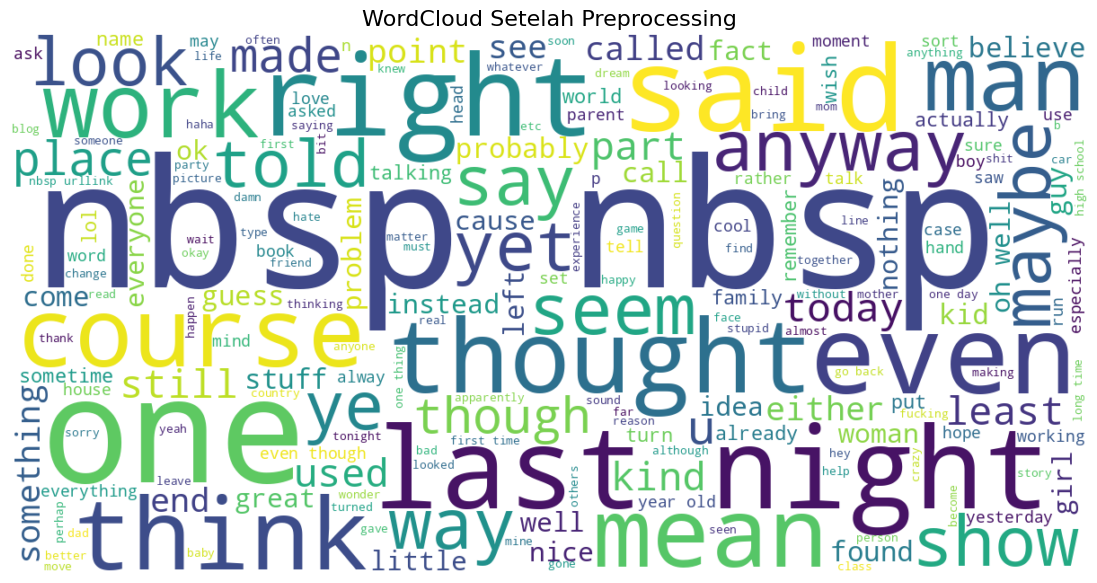

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

all_words = ' '.join(df['lemma_text'])

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(all_words)

plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Setelah Preprocessing", fontsize=16)
plt.show()

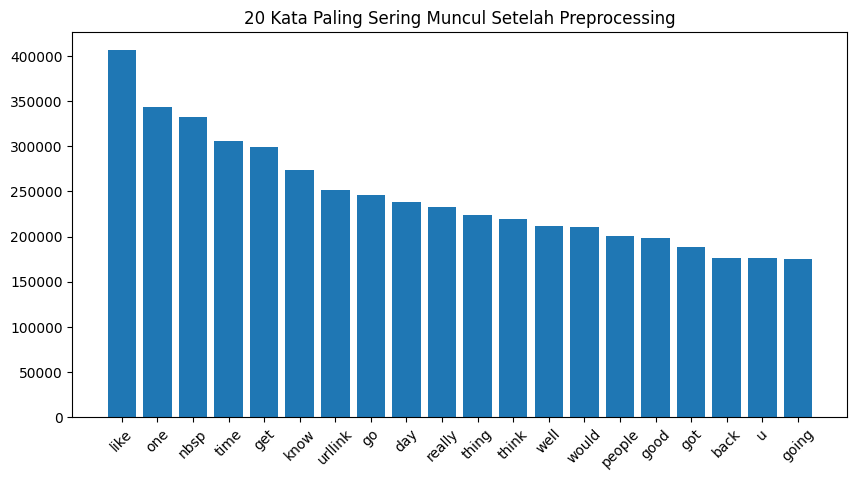

In [ ]:
words = all_words.split()
counter = Counter(words).most_common(20)

labels, counts = zip(*counter)

plt.figure(figsize=(10,5))
plt.bar(labels, counts)
plt.xticks(rotation=45)
plt.title("20 Kata Paling Sering Muncul Setelah Preprocessing")
plt.show()

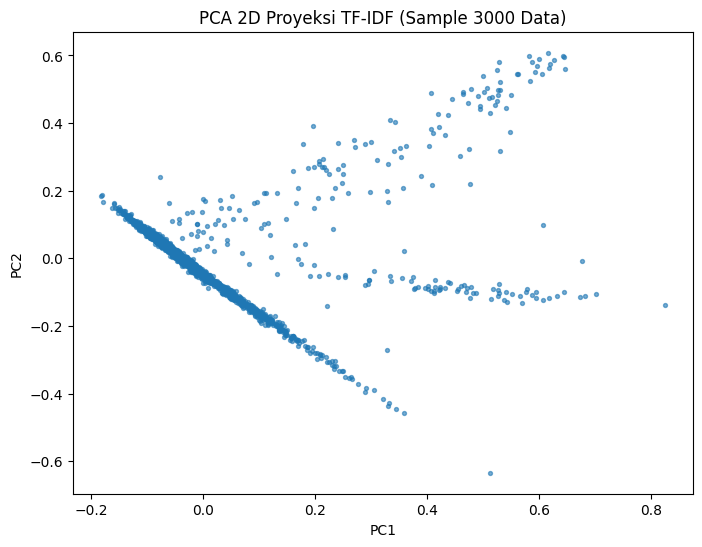

In [ ]:
from sklearn.decomposition import PCA

# Ambil sample agar PCA tidak berat
sample_size = 3000
idx = np.random.choice(X_tfidf.shape[0], sample_size, replace=False)

X_sample = X_tfidf[idx].toarray()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.6)
plt.title("PCA 2D Proyeksi TF-IDF (Sample 3000 Data)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Modelling

In [ ]:
from sklearn.model_selection import train_test_split

train_text, test_text = train_test_split(
    df["lemma_text"],
    test_size=0.2,
    random_state=42
)

print("Train size:", len(train_text))
print("Test size :", len(test_text))

Train size: 354340
Test size : 88586


# LATENT SEMANTIC ANALYSIS (LSA)

**Karakteristik Model**

Model linear algebra based, bukan probabilistic.

Menggunakan SVD untuk memecah matriks TF-IDF menjadi representasi konsep laten.

Cocok untuk teks panjang dan corpus besar.

Hasilnya berupa topik tunggal per komponen.

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_topics = 10

lsa_model = TruncatedSVD(
    n_components=n_topics,
    n_iter=10,
    random_state=42
)

lsa_train = lsa_model.fit_transform(X_tfidf)

In [ ]:
terms = tfidf.get_feature_names_out()

def get_lsa_topics(model, terms, n=15):
    topics = []
    for idx, comp in enumerate(model.components_):
        top_indices = comp.argsort()[-n:]
        topics.append([terms[i] for i in top_indices])
    return topics

lsa_topics = get_lsa_topics(lsa_model, terms)

In [ ]:
topic_range = [3,5,7,10,12,15]
explained_var = []

for t in topic_range:
    model = TruncatedSVD(n_components=t, random_state=42)
    model.fit(X_tfidf)
    explained_var.append(model.explained_variance_ratio_.sum())

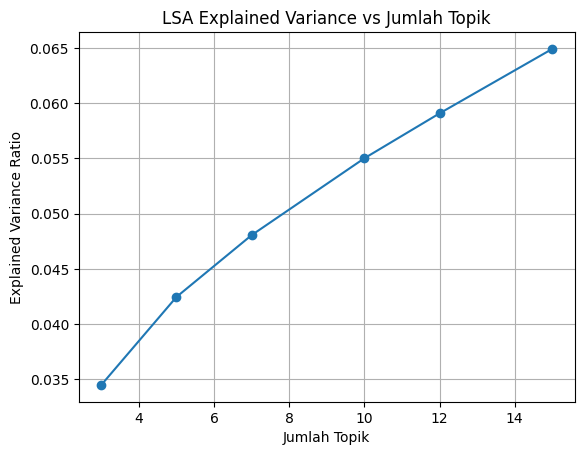

In [ ]:
plt.plot(topic_range, explained_var, marker='o')
plt.title("LSA Explained Variance vs Jumlah Topik")
plt.xlabel("Jumlah Topik")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

# LATENT DIRICHLET ALLOCATION (LDA)

**Karakteristik Model**

Model probabilistic generative:
“dokumen = campuran topik”, “topik = campuran kata”.

Cocok untuk interpretasi topik yang jelas.

Sangat bergantung pada n_components, alpha, beta.

In [ ]:
# from sklearn.decomposition import MiniBatchDictionaryLearning
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import CountVectorizer

# count_vect = CountVectorizer(
#     max_df=0.95,
#     min_df=5,
#     stop_words="english"
# )

# X_count = count_vect.fit_transform(df["lemma_text"])
# terms_count = count_vect.get_feature_names_out()

# # Removed TruncatedSVD here as LDA expects non-negative input, typically counts.
# # svd = TruncatedSVD(n_components=300, random_state=42)
# # X_reduced = svd.fit_transform(X_count)

# topic_range = [3, 5, 7, 10, 12, 15]
# scores = {}

# for t in topic_range:
#     lda_fast = LatentDirichletAllocation(
#         n_components=t,
#         learning_method='online',
#         max_iter=5,
#         batch_size=512,
#         random_state=42,
#         n_jobs=1
#     )
#     # Fit LDA directly on X_count (non-negative counts) instead of X_reduced
#     lda_fast.fit(X_count)
#     scores[t] = lda_fast.bound_

# print("Score setiap jumlah topik:")
# print(scores)

# best_k = max(scores, key=scores.get)
# print("Topik terbaik:", best_k)

Score setiap jumlah topik:
{3: np.float64(4165.399211143927), 5: np.float64(3983.28602610316), 7: np.float64(3995.575750398486), 10: np.float64(3930.827149296313), 12: np.float64(3890.7390214349352), 15: np.float64(3905.7690457214608)}
Topik terbaik: 3


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

count_vect = CountVectorizer(
    max_df=0.95,
    min_df=5,
    stop_words="english"
)

X_count = count_vect.fit_transform(df["lemma_text"])
terms_count = count_vect.get_feature_names_out()

scores = {
    3: 4165.399211143927,
    5: 3983.28602610316,
    7: 3995.575750398486,
    10: 3930.827149296313,
    12: 3890.7390214349352,
    15: 3905.7690457214608
}

print("Score setiap jumlah topik:")
print(scores)

best_k = max(scores, key=scores.get)
print("\nTopik terbaik:", best_k)

Score setiap jumlah topik:
{3: 4165.399211143927, 5: 3983.28602610316, 7: 3995.575750398486, 10: 3930.827149296313, 12: 3890.7390214349352, 15: 3905.7690457214608}

Topik terbaik: 3


In [ ]:
lda_fast = LatentDirichletAllocation(
    n_components=best_k,
    learning_method='online',
    max_iter=10,
    batch_size=512,
    random_state=42,
    n_jobs=1
)
lda_fast.fit(X_count)

LatentDirichletAllocation(batch_size=512, learning_method='online',
                          n_components=3, n_jobs=1, random_state=42)

In [ ]:
def get_lda_topics(model, terms, n=15):
    topics = []
    for comp in model.components_:
        top_idx = comp.argsort()[-n:]
        topics.append([terms[i] for i in top_idx])
    return topics

lda_topics_fast = get_lda_topics(lda_fast, terms_count)

print("\n=== TOPIK DARI LDA FAST ===")
for i, topic_words in enumerate(lda_topics_fast):
    print(f"Topic {i+1}: {topic_words}")


=== TOPIK DARI LDA FAST ===
Topic 1: ['feel', 'really', 'say', 'day', 'way', 'make', 'want', 'think', 'love', 'life', 'people', 'thing', 'time', 'know', 'like']
Topic 2: ['work', 'home', 'night', 'thing', 'think', 'know', 'good', 'today', 'going', 'went', 'time', 'day', 'really', 'got', 'like']
Topic 3: ['war', 'work', 'blog', 'said', 'site', 'world', 'american', 'bush', 'state', 'time', 'year', 'people', 'new', 'urllink', 'nbsp']


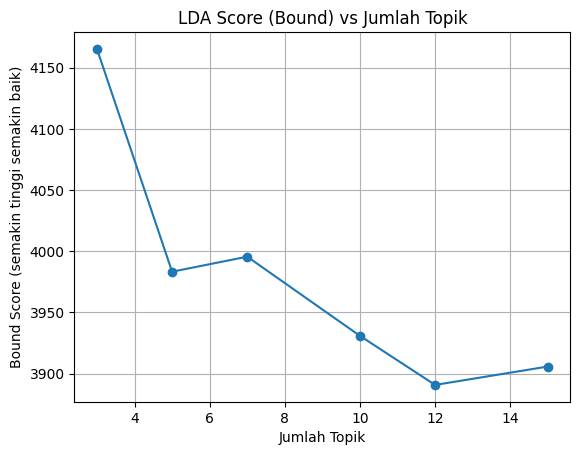

In [ ]:
plt.plot(topic_range, list(scores.values()), marker="o")
plt.title("LDA Score (Bound) vs Jumlah Topik")
plt.xlabel("Jumlah Topik")
plt.ylabel("Bound Score (semakin tinggi semakin baik)")
plt.grid(True)
plt.show()

=== WordCloud LSA Topics ===


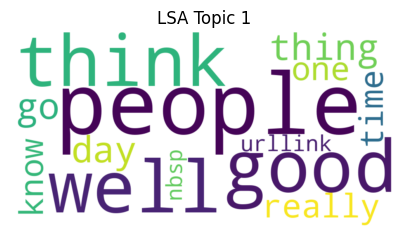

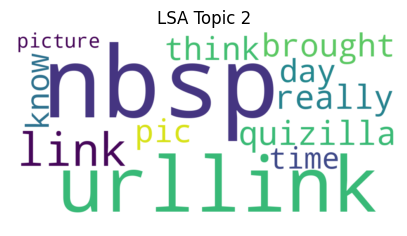

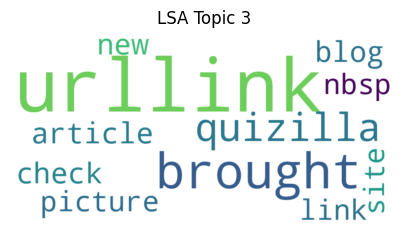

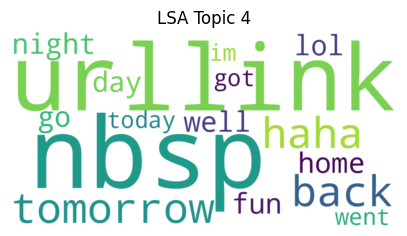

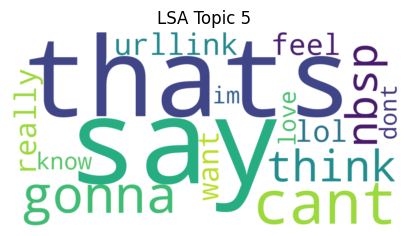

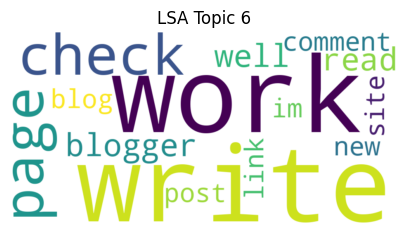

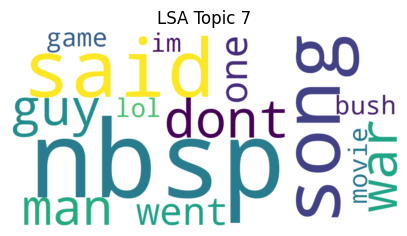

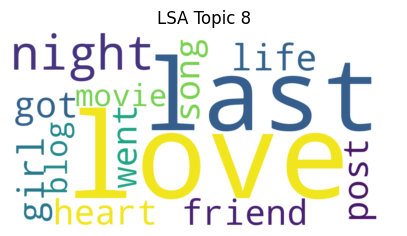

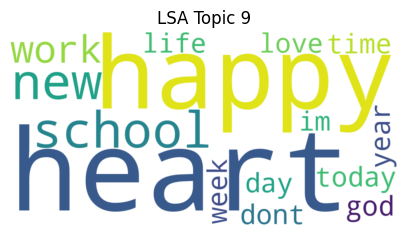

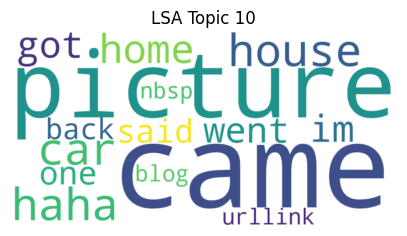

=== WordCloud LDA Topics ===


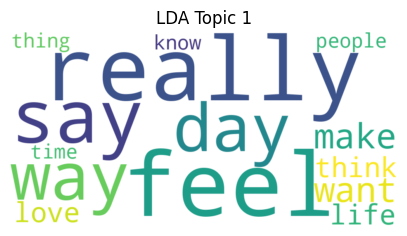

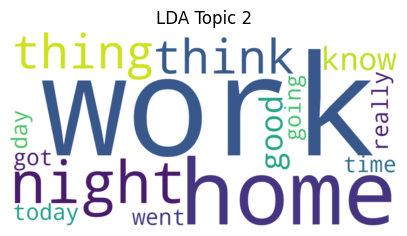

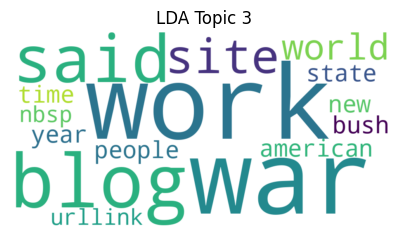

In [ ]:
# Perbandingan LDA dan LSA
def plot_wordcloud(topic_words, title):
    wc = WordCloud(background_color="white", width=1000, height=500)
    wc.generate(" ".join(topic_words))

    plt.figure(figsize=(5,3))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

print("=== WordCloud LSA Topics ===")
for i, topic_words in enumerate(lsa_topics):
    plot_wordcloud(topic_words, f"LSA Topic {i+1}")

print("=== WordCloud LDA Topics ===")
for i, topic_words in enumerate(lda_topics_fast):
    plot_wordcloud(topic_words, f"LDA Topic {i+1}")

# Evaluasi Model & Result Analysis

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 90.7 MB/s eta 0:00:00


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

cleaned_tokens = [doc.split() for doc in df["lemma_text"]]
id2word = corpora.Dictionary(cleaned_tokens)

def get_lsa_topics(lsa_model, vectorizer, topn=10):
    terms = vectorizer.get_feature_names_out()
    topics = []
    for comp in lsa_model.components_:
        words = [terms[i] for i in comp.argsort()[:-topn - 1:-1]]
        topics.append(words)
    return topics

lsa_topics = get_lsa_topics(lsa_model, tfidf)

coherence_lsa = CoherenceModel(
    topics=lsa_topics,
    texts=cleaned_tokens,
    dictionary=id2word,
    coherence='c_v'
).get_coherence()

print("LSA Coherence Score:", coherence_lsa)

# --- Variance Ratio (LSA metric) ---
variance_ratio = lsa_model.explained_variance_ratio_.sum()
print("LSA Explained Variance Ratio:", variance_ratio)

LSA Coherence Score: 0.495218007759276
LSA Explained Variance Ratio: 0.05505840132862155


In [ ]:
from gensim import matutils

corpus = matutils.Sparse2Corpus(X_count, documents_columns=False)

# Coherence
coherence_lda = CoherenceModel(
    topics=lda_topics_fast,
    texts=cleaned_tokens,
    dictionary=id2word,
    coherence='c_v'
).get_coherence()

print("LDA Coherence (C_v):", coherence_lda)

# Perplexity
perplexity = lda_fast.perplexity(X_count)
print("LDA Perplexity:", perplexity)

LDA Coherence (C_v): 0.40555345662870507
LDA Perplexity: 4158.867445978027


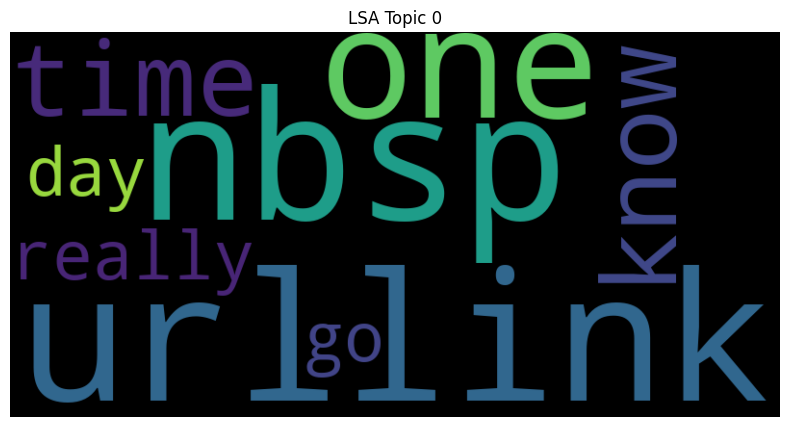

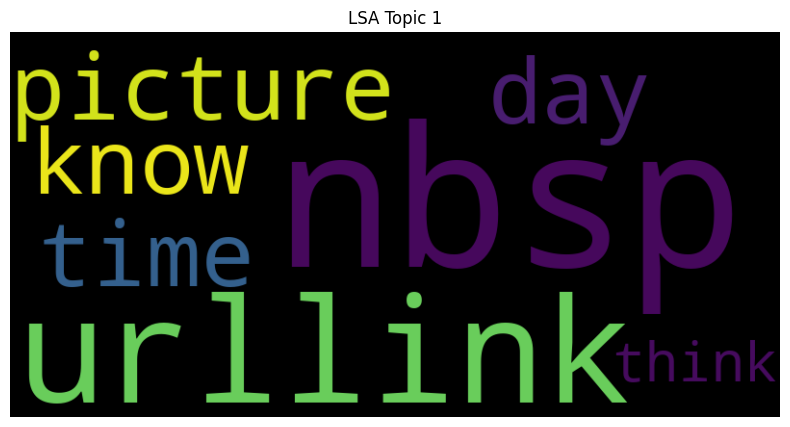

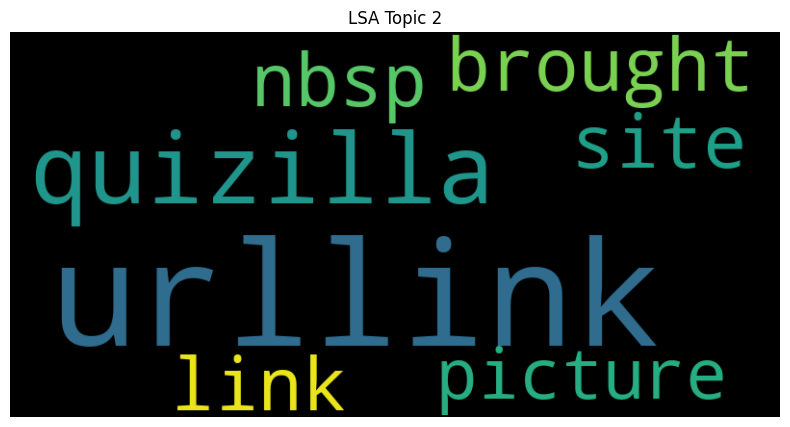

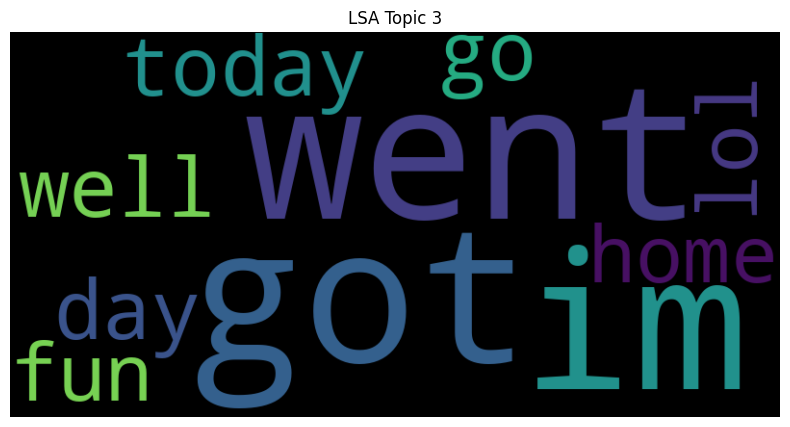

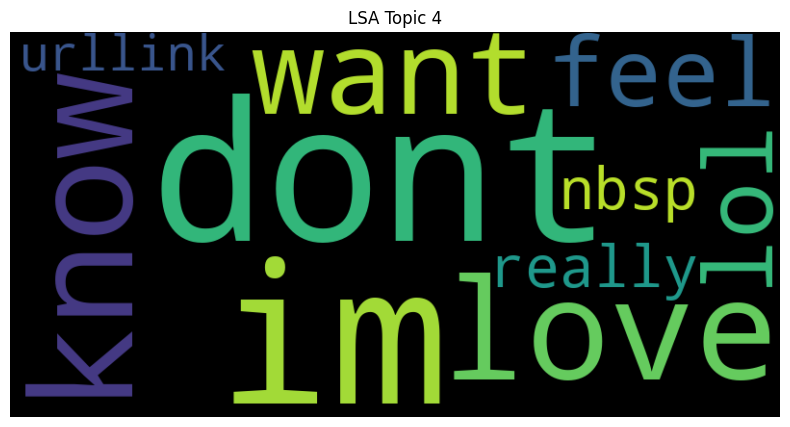

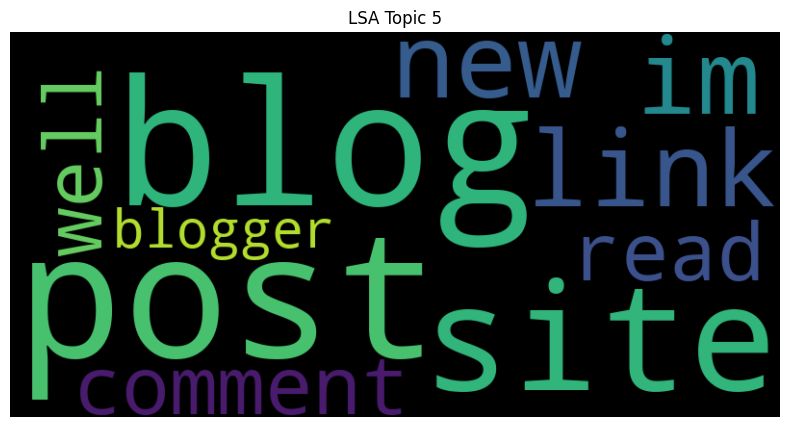

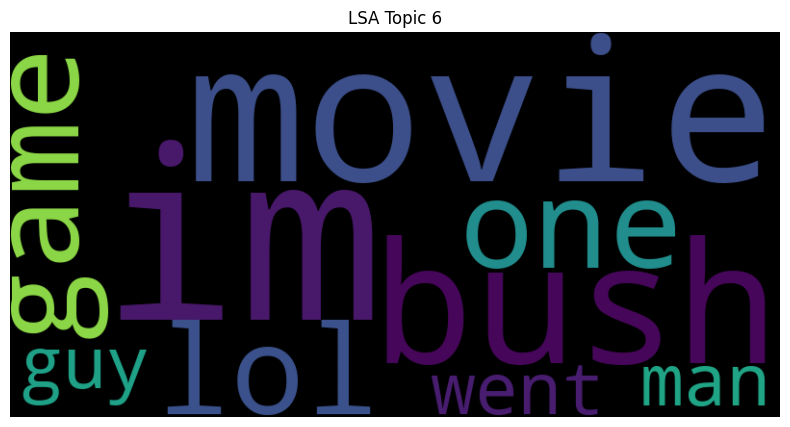

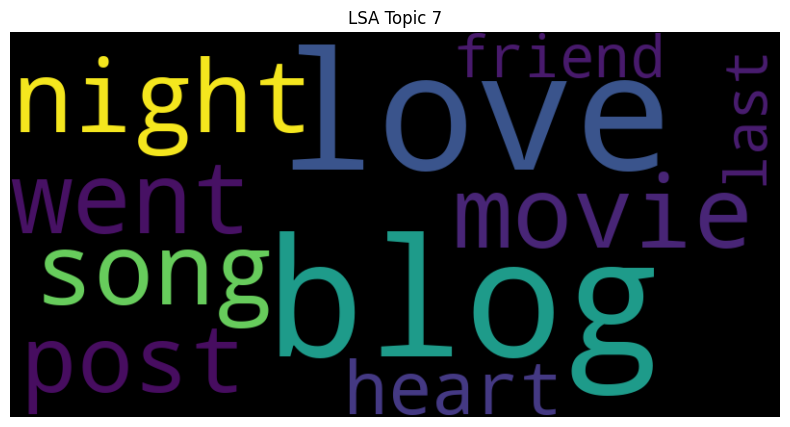

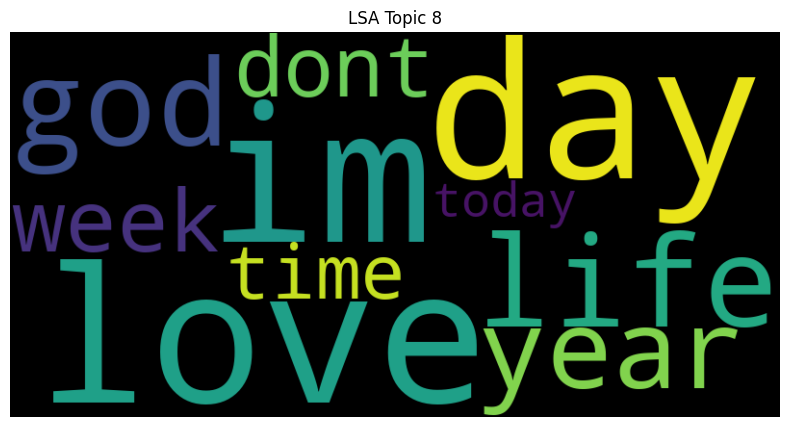

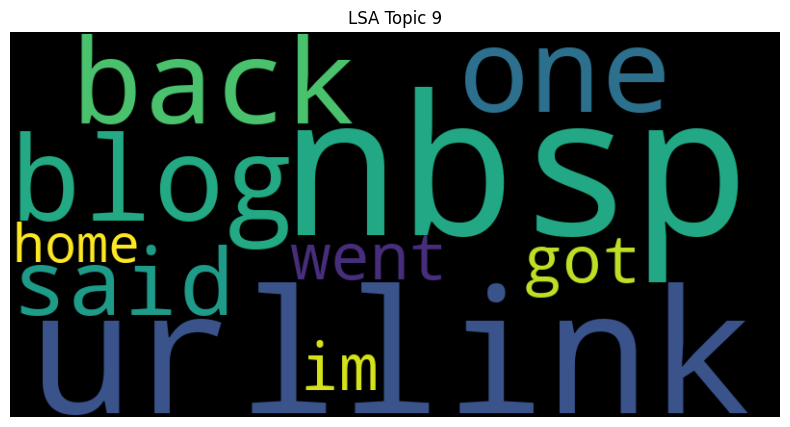

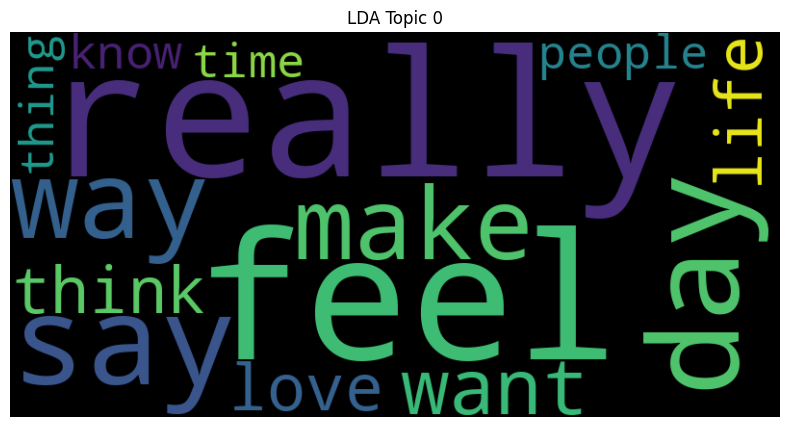

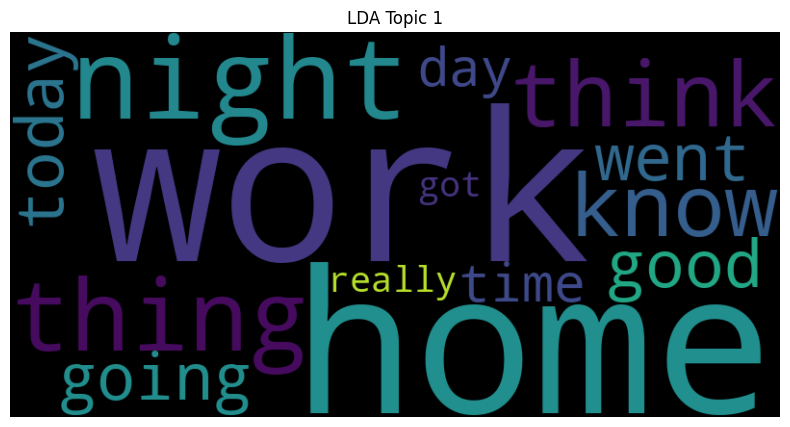

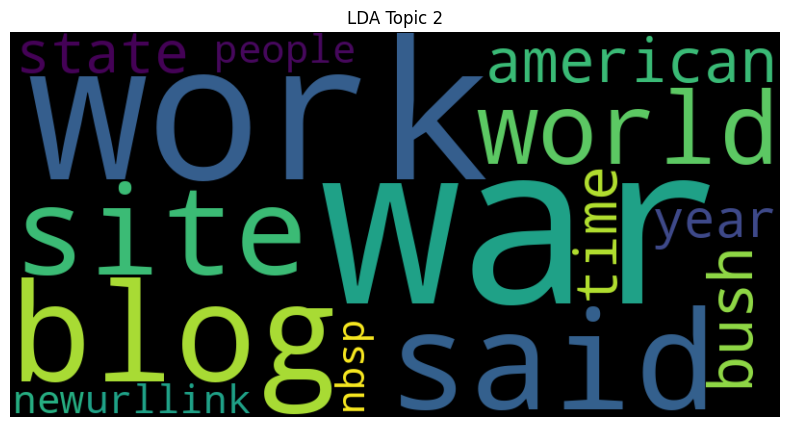

In [ ]:
def plot_wordcloud(words, title):
    text = " ".join(words)
    wc = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# --- LSA Wordcloud ---
for i, topic_words in enumerate(lsa_topics):
    plot_wordcloud(topic_words, f"LSA Topic {i}")

# --- LDA Wordcloud ---
# The `get_lda_topics` function (defined in cell qpzDZCeWwm73) is used for sklearn's LDA model.
# It returns a list of lists, where each inner list contains the top words for a topic.
lda_topics_for_plot = get_lda_topics(lda_fast, terms_count)
for i, topic_words in enumerate(lda_topics_for_plot):
    plot_wordcloud(topic_words, f"LDA Topic {i}")

In [ ]:
for i, topic in enumerate(lsa_topics):
    print(f"LSA Topic {i}: {topic}")

LSA Topic 0: ['nbsp', 'urllink', 'like', 'one', 'get', 'time', 'know', 'really', 'day', 'go']
LSA Topic 1: ['nbsp', 'urllink', 'nbsp urllink', 'nbsp nbsp', 'urllink urllink', 'picture', 'time nbsp', 'day nbsp', 'nbsp know', 'nbsp think']
LSA Topic 2: ['urllink', 'nbsp urllink', 'urllink urllink', 'link', 'com', 'site', 'brought urllink', 'quizilla', 'urllink quizilla', 'picture']
LSA Topic 3: ['went', 'got', 'im', 'today', 'well', 'day', 'go', 'lol', 'home', 'fun']
LSA Topic 4: ['im', 'dont', 'love', 'like', 'know', 'want', 'feel', 'lol', 'really', 'nbsp urllink']
LSA Topic 5: ['blog', 'post', 'site', 'link', 'new', 'im', 'comment', 'read', 'well', 'blogger']
LSA Topic 6: ['im', 'movie', 'like', 'bush', 'lol', 'game', 'one', 'went', 'guy', 'man']
LSA Topic 7: ['love', 'blog', 'night', 'movie', 'song', 'went', 'post', 'heart', 'friend', 'last']
LSA Topic 8: ['im', 'love', 'day', 'life', 'god', 'year', 'week', 'dont', 'time', 'today']
LSA Topic 9: ['nbsp urllink', 'blog', 'back', 'one', 

In [ ]:
for i, topic_words in enumerate(lda_topics_fast):
    print(f"\nLDA Topic {i}:")
    print(topic_words)


LDA Topic 0:
['feel', 'really', 'say', 'day', 'way', 'make', 'want', 'think', 'love', 'life', 'people', 'thing', 'time', 'know', 'like']

LDA Topic 1:
['work', 'home', 'night', 'thing', 'think', 'know', 'good', 'today', 'going', 'went', 'time', 'day', 'really', 'got', 'like']

LDA Topic 2:
['war', 'work', 'blog', 'said', 'site', 'world', 'american', 'bush', 'state', 'time', 'year', 'people', 'new', 'urllink', 'nbsp']
